## Introduction to Multi-Fidelity Optimization

在上一个教程中，我们学习了如何实现一个简单的AutoML系统。但这个AutoML系统的核心：贝叶斯优化算法往往需要大量对采样的评价才能获得比较好的结果。

然而，在自动机器学习(Automatic Machine Learning, AutoML)任务中评价往往通过 k 折交叉验证获得，在大数据集的机器学习任务上，`获得一个评价的时间代价巨大`。这也影响了优化算法在自动机器学习问题上的效果。所以一些`减少评价代价`的方法被提出来，其中**多保真度优化**(Multi-Fidelity Optimization)[<sup>[1]</sup>](#refer-anchor-1)就是其中的一种。而**多臂老虎机算法**(Multi-armed Bandit Algorithm, MBA)[<sup>[2]</sup>](#refer-anchor-2)是多保真度算法的一种。在此基础上，有两种主流的`bandit-based`优化策略：

- Successive Halving (SH) [<sup>[3]</sup>](#refer-anchor-3)
- Hyperband (HB) [<sup>[4]</sup>](#refer-anchor-4)



首先我们介绍连续减半(Successive Halving ,SH)。在连续减半策略中， 我们将`评价代价`参数化为一个变量`budget`，即预算。根据BOHB论文[<sup>[5]</sup>](#refer-anchor-5)的阐述，我们可以根据不同的场景定义不同的budget，举例如下：

1. 迭代算法的迭代数(如：神经网络的epoch、随机森林，GBDT的树的个数)
2. 机器学习算法所使用的样本数
3. 贝叶斯神经网络[<sup>[6]</sup>](#refer-anchor-6)中MCMC链的长度
4. 深度强化学习中的尝试数


举例说明，我们定义$budget_{max}=1$, $budget_{min}=\frac{1}{8}$, $\eta=2$ (`eta` = 2) 。在这里`budget`的语义表示使用$100\times budget$%的样本。

1. 首先我们从配置空间(或称为超参空间)**随机采样**8个配置，实例化为8个机器学习模型。
2. 然后用$\frac{1}{8}$的训练样本训练这8个模型并在验证集得到相应的损失值。
3. 保留这8个模型中loss最低的前4个模型，其余的舍弃。
4. 依次类推，最后仅保留一个模型，并且其`budget=1`(可以用全部的样本进行训练)

![SH](https://img-blog.csdnimg.cn/20201228104418342.png)

上图描述了例子中的迭代过程(图片来自[<sup>[1]</sup>](#refer-anchor-1)) 。我们可以用`ultraopt.multi_fidelity`中的`SuccessiveHalvingIterGenerator`来实例化这一过程：

In [1]:
from ultraopt.multi_fidelity import SuccessiveHalvingIterGenerator, HyperBandIterGenerator

In [2]:
SH = SuccessiveHalvingIterGenerator(min_budget=1/8, max_budget=1, eta=2)
SH.get_table()

iter 0                        
           stage 0 stage 1 stage 2 stage 3
num_config       8       4       2       1
budget         1/8     1/4     1/2       1

接下来我们介绍HyperBand(HB)的策略。

In [3]:
SH = HyperBandIterGenerator(min_budget=1/8, max_budget=1, eta=2)
SH.get_table()

iter 0                          iter 1                  iter 2  \
           stage 0 stage 1 stage 2 stage 3 stage 0 stage 1 stage 2 stage 0   
num_config       8       4       2       1       4       2       1       4   
budget         1/8     1/4     1/2       1     1/4     1/2       1     1/2   

                    iter 3  
           stage 1 stage 0  
num_config       2       4  
budget           1       1

### Combine Multi-Fidelity Optimization and Bayesian Optimization in UltraOpt

我们注意到，上文描述的SH和HB策略在采样时都是**随机采样**，而`UltraOpt`将**优化器**和**多保真迭代生成器**这两个部分解耦和了，您可以将任意的**贝叶斯优化算法**和**多保真优化算法**进行组合。

这样的组合其实就是BOHB(Bayesian Optimization Hyperband)算法[<sup>[5]</sup>](#refer-anchor-5)。UltraOpt在很多代码上借鉴和直接使用了HpBandSter[<sup>[7]</sup>](#refer-anchor-7)这个开源项目，我们感谢他们优秀的工作。

如果您需要采用多保真优化策略，您的评价函数需要增加一个`float`类型的`budget`参数：

```python
def evaluate(config: dict, budget:float) -> float :
    pass
```

为了测试， 我们采用`ultraopt.tests.mock`中自带的一个含有`budget`的评价函数，以及相应的配置空间：

In [4]:
from ultraopt.tests.mock import evaluate, config_space
from ultraopt import fmin
from ultraopt.multi_fidelity import HyperBandIterGenerator

在调用`ultraopt.fmin`函数时，采用多保真策略时需要做以下修改：

1. 需要指定`multi_fidelity_iter_generator`(多保真迭代生成器)
2. `n_iterations`参数与普通模式不同，不再代表评价函数的调用次数，而代表`iter_generator`的迭代次数，需要酌情设置
3. `parallel_strategy`需要设置为`AsyncComm`，不改变默认值就没事

首先我们实例化一个`iter_generator`(多保真迭代生成器)，并根据`get_table()`函数的可视化结果设置`n_iterations`。

因为测试函数的`max_budget = 100`, 我们按照`25, 50, 100`来递增`budget`：

In [5]:
iter_generator = HyperBandIterGenerator(min_budget=25, max_budget=100, eta=2)
iter_generator.get_table()

iter 0                  iter 1          iter 2
           stage 0 stage 1 stage 2 stage 0 stage 1 stage 0
num_config       4       2       1       2       1       3
budget          25      50     100      50     100     100

In [6]:
result = fmin(evaluate, config_space, n_iterations=50, multi_fidelity_iter_generator=iter_generator, n_jobs=3)
result

100%|██████████| 218/218 [00:00<00:00, 247.44trial/s, max budget: 100.0, best loss: 0.540]


+------------------------------------------------------+
| HyperParameters | Optimal Value                      |
+-----------------+---------------+--------+-----------+
| x0              | 0.1594        | 0.0317 | 0.2921    |
| x1              | 3.3435        | 1.8980 | 0.0657    |
+-----------------+---------------+--------+-----------+
| Budgets         | 25            | 50     | 100 (max) |
+-----------------+---------------+--------+-----------+
| Optimal Loss    | 5.6924        | 4.0304 | 0.5397    |
+-----------------+---------------+--------+-----------+
| Num Configs     | 68            | 68     | 82        |
+-----------------+---------------+--------+-----------+

按budget分组的随时间变化拟合曲线：

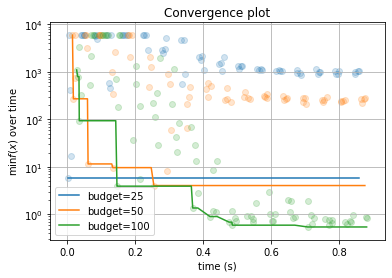

In [7]:
result.plot_convergence_over_time(yscale="log");

`low_budget`推荐得到的优势配置会保留到`high_budget`，从而可以根据`loss-pairs`计算不同`budget`之间的相关性：

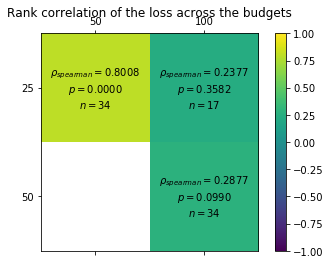

In [8]:
result.plot_correlation_across_budgets();

### Multi-Fidelity in AutoML Scenarios

虽然`ultraopt.tests.mock`中提供的合成函数可以测试结合多保真策略的优化，但这毕竟不是真实场景。

现在，我们就通过修改教程`05. Implement a Simple AutoML System`中的AutoML评价器，将其改造为一个支持多保真优化的评价器，并进行相应的测试。

In [9]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
import seaborn as sns
import numpy as np
import warnings
from ultraopt.hdl import layering_config
from sklearn.model_selection import StratifiedKFold # 采用分层抽样

warnings.filterwarnings("ignore")
X, y = load_digits(return_X_y=True)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

def evaluate(config: dict, budget: float) -> float:
    layered_dict = layering_config(config) 
    AS_HP = layered_dict['classifier'].copy()
    AS, HP = AS_HP.popitem()
    ML_model = eval(AS)(**HP)
    # 注释掉采用原版的采用所有数据进行训练的方法(相当于budget=1)
    # scores = cross_val_score(ML_model, X, y, cv=cv, scoring=metric)
    # -------------------------------------------------------------
    # 采用在对【 5折交叉验证中的训练集 】进行采样的方法，采样率为 budget
    sample_ratio  = budget 
    scores = []
    for i, (train_ix, valid_ix) in enumerate(cv.split(X, y)):
        rng = np.random.RandomState(i)
        size = int(train_ix.size * sample_ratio)
        train_ix = rng.choice(train_ix, size, replace=False)
        X_train = X[train_ix, :]
        y_train = y[train_ix]
        X_valid = X[valid_ix, :]
        y_valid = y[valid_ix]
        ML_model.fit(X_train, y_train)
        scores.append(ML_model.score(X_valid, y_valid))
    # -------------------------------------------------------------
    score = np.mean(scores)
    return 1 - score

In [10]:
config = {'classifier:__choice__': 'LinearSVC',
 'classifier:LinearSVC:C': 1.0,
 'classifier:LinearSVC:dual': 'True:bool',
 'classifier:LinearSVC:loss': 'squared_hinge',
 'classifier:LinearSVC:max_iter': 600,
 'classifier:LinearSVC:multi_class': 'ovr',
 'classifier:LinearSVC:penalty': 'l2',
 'classifier:LinearSVC:random_state': '42:int'}

In [11]:
evaluate(config, 0.125)

0.12298274902615469

In [12]:
evaluate(config, 0.5)

0.0690038953811909

In [13]:
evaluate(config, 1)

0.05286588759042843

可以看到我们已经成功定义了一个结合多保真策略的AutoML评价器，并且按照一般规律：budget越大，评价代价也越大，模型表现也越好，loss越小。

我们将上述代码整合到`05. Implement a Simple AutoML System.py`脚本中，形成`06. Combine Multi-Fidelity Optimization.py`脚本：

In [14]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Author  : qichun tang
# @Date    : 2020-12-28
# @Contact    : qichun.tang@bupt.edu.cn
import warnings

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold  # 采用分层抽样
from sklearn.model_selection import cross_val_score
import sklearn.metrics
import numpy as np

from ultraopt import fmin
from ultraopt.hdl import hdl2cs, plot_hdl, layering_config
from ultraopt.multi_fidelity import HyperBandIterGenerator

warnings.filterwarnings("ignore")
HDL = {
    'classifier(choice)':{
        "LinearSVC": {
          "max_iter": {"_type": "int_quniform","_value": [300, 3000, 100], "_default": 600},
          "penalty":  {"_type": "choice", "_value": ["l1", "l2"],"_default": "l2"},
          "dual": {"_type": "choice", "_value": [True, False],"_default": False},
          "loss":  {"_type": "choice", "_value": ["hinge", "squared_hinge"],"_default": "squared_hinge"},
          "C": {"_type": "loguniform", "_value": [0.01, 10000],"_default": 1.0},
          "multi_class": "ovr",
          "random_state": 42,
          "__forbidden": [
              {"penalty": "l1","loss": "hinge"},
              {"penalty": "l2","dual": False,"loss": "hinge"},
              {"penalty": "l1","dual": False},
              {"penalty": "l1","dual": True,"loss": "squared_hinge"},
          ]
        },
        "RandomForestClassifier": {
          "n_estimators": {"_type": "int_quniform","_value": [10, 200, 10], "_default": 100},
          "criterion": {"_type": "choice","_value": ["gini", "entropy"],"_default": "gini"},
          "max_features": {"_type": "choice","_value": ["sqrt","log2"],"_default": "sqrt"},
          "min_samples_split": {"_type": "int_uniform", "_value": [2, 20],"_default": 2},
          "min_samples_leaf": {"_type": "int_uniform", "_value": [1, 20],"_default": 1},
          "bootstrap": {"_type": "choice","_value": [True, False],"_default": True},
          "random_state": 42
        },
        "KNeighborsClassifier": {
          "n_neighbors": {"_type": "int_loguniform", "_value": [1,100],"_default": 3},
          "weights" : {"_type": "choice", "_value": ["uniform", "distance"],"_default": "uniform"},
          "p": {"_type": "choice", "_value": [1, 2],"_default": 2},
        },
    }
}
CS = hdl2cs(HDL)
g = plot_hdl(HDL)
default_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
X, y = load_digits(return_X_y=True)

class Evaluator():
    def __init__(self,
                 X, y,
                 metric="accuracy",
                 cv=default_cv):
        # 初始化
        self.X = X
        self.y = y
        self.metric = metric
        self.cv = cv

    def __call__(self, config: dict, budget: float) -> float:
        layered_dict = layering_config(config)
        AS_HP = layered_dict['classifier'].copy()
        AS, HP = AS_HP.popitem()
        ML_model = eval(AS)(**HP)
        # scores = cross_val_score(ML_model, self.X, self.y, cv=self.cv, scoring=self.metric)
        # -------------------------------------------------------------
        # 采用在对【 5折交叉验证中的训练集 】进行采样的方法，采样率为 budget
        sample_ratio  = budget
        scores = []
        for i, (train_ix, valid_ix) in enumerate(self.cv.split(X, y)):
            rng = np.random.RandomState(i)
            size = int(train_ix.size * sample_ratio)
            train_ix = rng.choice(train_ix, size, replace=False)
            X_train = X[train_ix, :]
            y_train = y[train_ix]
            X_valid = X[valid_ix, :]
            y_valid = y[valid_ix]
            ML_model.fit(X_train, y_train)
            y_pred = ML_model.predict(X_valid)
            score = eval(f"sklearn.metrics.{self.metric}_score")(y_valid, y_pred)
            scores.append(score)
        # -------------------------------------------------------------
        score = np.mean(scores)
        return 1 - score

evaluator = Evaluator(X, y)
iter_generator = HyperBandIterGenerator(min_budget=1/4, max_budget=1, eta=2)
result = fmin(evaluator, HDL, optimizer="ETPE", n_iterations=30, multi_fidelity_iter_generator=iter_generator, n_jobs=3)
print(result)

100%|██████████| 130/130 [00:31<00:00,  4.10trial/s, max budget: 1.0, best loss: 0.012]
+--------------------------------------------------------------------------------------------------------------------------+
| HyperParameters                                     | Optimal Value                                                      |
+-----------------------------------------------------+----------------------+----------------------+----------------------+
| classifier:__choice__                               | KNeighborsClassifier | KNeighborsClassifier | KNeighborsClassifier |
| classifier:KNeighborsClassifier:n_neighbors         | 5                    | 4                    | 4                    |
| classifier:KNeighborsClassifier:p                   | 2:int                | 2:int                | 2:int                |
| classifier:KNeighborsClassifier:weights             | distance             | distance             | distance             |
| classifier:LinearSVC:C             

我们可以对结合多保真策略得到的优化结果进行数据分析：

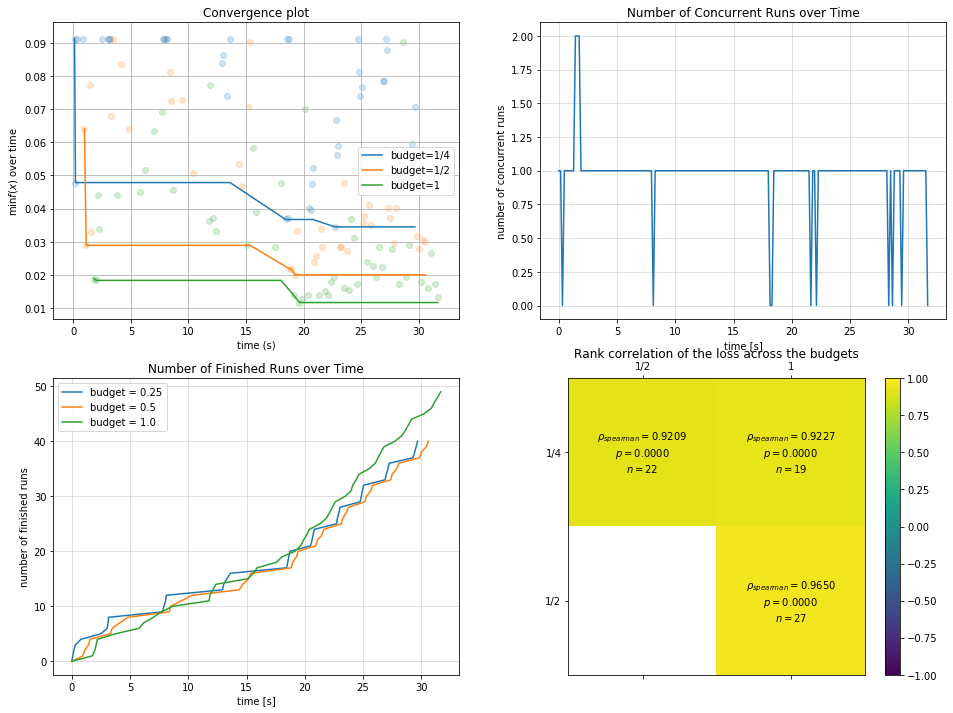

In [17]:
import pylab as plt
plt.rcParams['figure.figsize'] = (16, 12)
plt.subplot(2, 2, 1)
result.plot_convergence_over_time();
plt.subplot(2, 2, 2)
result.plot_concurrent_over_time(num_points=200);
plt.subplot(2, 2, 3)
result.plot_finished_over_time();
plt.subplot(2, 2, 4)
result.plot_correlation_across_budgets();

图1的`budget分组拟合曲线`和图4`多budget间相关性图`我们在之前已经介绍过了，图2和图3分别阐述了`随时间的并行数`和`随时间的完成情况`。

---

**参考文献**



<div id="refer-anchor-1"></div>

- [1] [Feurer M., Hutter F. (2019) Hyperparameter Optimization. In: Hutter F., Kotthoff L., Vanschoren J. (eds) Automated Machine Learning. The Springer Series on Challenges in Machine Learning. Springer, Cham.](https://link.springer.com/chapter/10.1007/978-3-030-05318-5_1#citeas)

<div id="refer-anchor-2"></div>

- [2] [Bouneffouf, Djallel and Irina Rish. “A Survey on Practical Applications of Multi-Armed and Contextual Bandits.” ArXiv abs/1904.10040 (2019): n. pag.](https://arxiv.org/abs/1904.10040)

<div id="refer-anchor-3"></div>

- [3] [Jamieson, K. and Ameet Talwalkar. “Non-stochastic Best Arm Identification and Hyperparameter Optimization.” AISTATS (2016).](https://arxiv.org/abs/1502.07943)

<div id="refer-anchor-4"></div>

- [4] [Li, L. et al. “Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization.” J. Mach. Learn. Res. 18 (2017): 185:1-185:52.](https://arxiv.org/abs/1603.06560)

<div id="refer-anchor-5"></div>

- [5] [Falkner, Stefan et al. “BOHB: Robust and Efficient Hyperparameter Optimization at Scale.” ICML (2018).](https://arxiv.org/abs/1807.01774)

<div id="refer-anchor-6"></div>

- [6] [https://github.com/automl/pybnn](https://github.com/automl/pybnn)


<div id="refer-anchor-7"></div>

- [7] [https://github.com/automl/HpBandSter](https://github.com/automl/HpBandSter)